In [ ]:
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from rliable import metrics
from rliable import library as rly

In [10]:
six_bins_fp = "../../results/cartpole/run_six_bins/robustness_experiment.pkl"
eight_bins_fp = "../../results/cartpole/run_eight_bins/robustness_experiment.pkl"

def load_data(fp: str):
    with open(fp, "rb") as f:
        six_bins_data = pickle.load(f)

    df_data = []
    # the data contains runs for a seed - each seed has 20 experiments with different
    # lengths - and at each length there are 250 evaluations - so need to unnest and
    # extract the relevant info.
    for exp in six_bins_data:
        seed = exp['seed']
        results = exp['results']
        for run in results:
            length = run['length']
            for i in range(250):
                returns_conf = run['returns_conf'][i]
                returns_noconf = run['returns_noconf'][i]
                run_info = {
                    'seed': seed,
                    'run': i,
                    'length': length,
                    'returns_conf': returns_conf,
                    'returns_noconf': returns_noconf,
                }
                df_data.append(run_info)
    
    return pd.DataFrame(df_data)

In [26]:
df_raw.head()

,seed,run,length,returns_conf_6,returns_noconf
0,0,0,0.1,16.0,11.0
1,0,1,0.1,12.0,11.0
2,0,2,0.1,14.0,20.0
3,0,3,0.1,17.0,12.0
4,0,4,0.1,16.0,18.0


,seed,run,length,returns_conf_8
0,0,0,0.1,16.0
1,0,1,0.1,231.0
2,0,2,0.1,12.0
3,0,3,0.1,11.0
4,0,4,0.1,11.0
...,...,...,...,...
124995,24,245,2.0,164.0
124996,24,246,2.0,74.0
124997,24,247,2.0,61.0
124998,24,248,2.0,92.0


In [100]:
# Combine the 6-binned and 8-binned data
df_raw = load_data(six_bins_fp)
df_raw = df_raw.rename(columns={'returns_conf': 'returns_conf_6'})

df_eight = load_data(eight_bins_fp)
df_raw['returns_conf_8'] = df_eight['returns_conf']

df_grp = df_raw.groupby(['seed', 'length']).mean().reset_index()
# if training went properly this should be 500
# let's see what happens if we filter these seeds out - since the training kind of blew up
default_runs = df_grp[df_grp['length'] == 0.5]
bad_seeds = default_runs.loc[default_runs['returns_noconf'] < 490, 'seed'].to_list()

df_filtered = df_grp[~df_grp['seed'].isin(bad_seeds)].drop(columns='run')
# df_filtered = df_grp

## Simple Median Plot

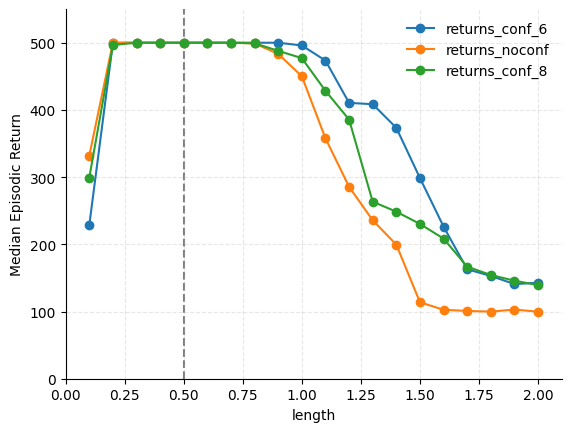

In [101]:
# median plot looks pretty tasty
medians = df_filtered.groupby('length')[['returns_conf_6', 'returns_noconf', 'returns_conf_8']].median()
ax = medians.plot(marker='o')
ax.set_ylabel('Median Episodic Return')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, 550)
ax.set_xlim(0.0, 2.1)
ax.grid(alpha=0.3, linestyle='--')
ax.axvline(0.5, linestyle='--', color='k', zorder=0, alpha=0.5)
ax.legend(frameon=False);

## IQM + 95% CI using Rliable

In [102]:
returns_conf_clean = df_filtered.pivot(index='seed', columns='length', values='returns_conf_8').to_numpy()
returns_conf_clean = returns_conf_clean.reshape(-1, 1, 20)
returns_noconf_clean = df_filtered.pivot(index='seed', columns='length', values='returns_noconf').to_numpy()
returns_noconf_clean = returns_noconf_clean.reshape(-1, 1, 20)

In [103]:
score_dict = {
    'No Calibration': returns_noconf_clean,
    'Train-time Calibration': returns_conf_clean,
}

iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., length])
                               for length in range(scores.shape[-1])])

aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
  score_dict, iqm, reps=50_000)

Text(0.5, 0.98, 'Performance of fixed agent on Cartpole under distribution shift')

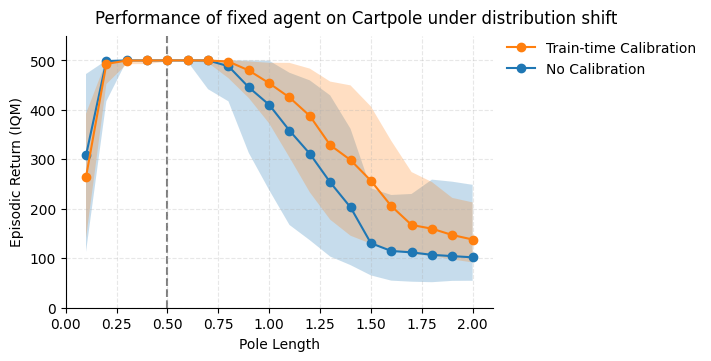

In [104]:
lengths = np.linspace(0.1, 2.0, 20)
fig, ax = plt.subplots(figsize=(7, 3.5), layout="constrained")  # or constrained_layout=True

for algo in aggregate_scores:
    iqms = aggregate_scores[algo]
    lower, upper = aggregate_score_cis[algo]
    ax.plot(lengths, iqms, marker="o", label=algo)
    ax.fill_between(lengths, lower, upper, alpha=0.25)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylim(0, 550)
ax.set_xlim(0.0, 2.1)
ax.grid(alpha=0.3, linestyle="--")
ax.axvline(0.5, linestyle="--", color="k", zorder=0, alpha=0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0, reverse=True);
ax.set_ylabel("Episodic Return (IQM)")
ax.set_xlabel("Pole Length")
fig.suptitle('Performance of fixed agent on Cartpole under distribution shift')

## Ratio Plot

In [105]:
df_filtered['ratio'] = df_filtered['returns_conf_6'] / df_filtered['returns_noconf']
ratio_clean = df_filtered.pivot(index='seed', columns='length', values='ratio').to_numpy().reshape(-1, 1, 20)
df_filtered
ratio_dict = {'Ratio': ratio_clean}

ratio_score, ratio_cis = rly.get_interval_estimates(
  ratio_dict, iqm, reps=50_000)

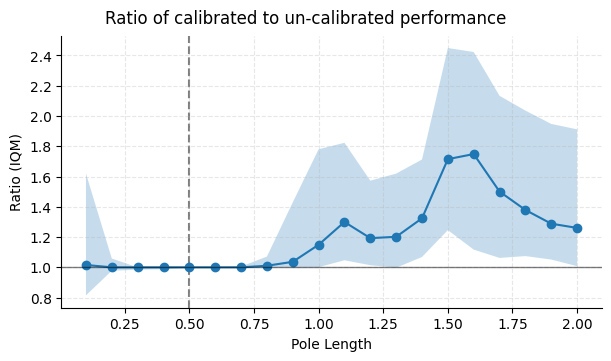

In [106]:
lengths = np.linspace(0.1, 2.0, 20)

fig, ax = plt.subplots(figsize=(6, 3.5), layout="constrained")  # or constrained_layout=True
for algo in ratio_score:
    iqms = ratio_score[algo]
    lower, upper = ratio_cis[algo]
    ax.plot(lengths, iqms, marker="o", label=algo)
    ax.fill_between(lengths, lower, upper, alpha=0.25)

ax.axhline(1.0, c='k', alpha=0.5, linewidth=1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(alpha=0.3, linestyle="--")
ax.axvline(0.5, linestyle="--", color="k", zorder=0, alpha=0.5)
ax.set_ylabel("Ratio (IQM)")
ax.set_xlabel("Pole Length")
fig.suptitle('Ratio of calibrated to un-calibrated performance');

In [107]:
iqms.mean(), lower.mean(), upper.mean()

(np.float64(1.2060583145236445),
 np.float64(1.0223909830188178),
 np.float64(1.5795633285930926))

## Probability of Improvement

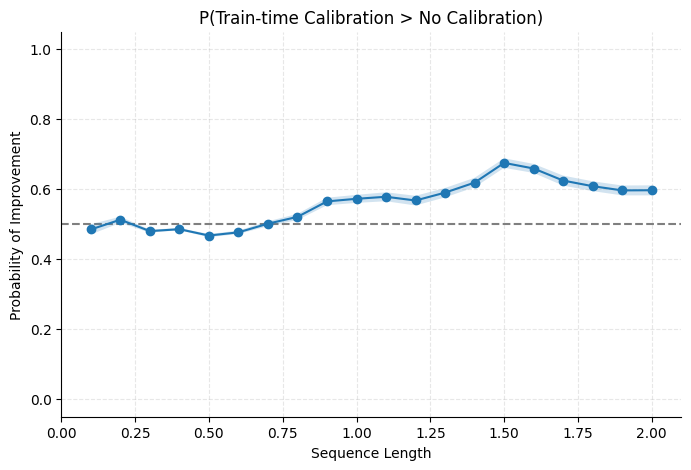

In [ ]:
import numpy as np
from rliable import library as rly
from rliable import metrics

# Assumes 'returns_conf_clean' and 'returns_noconf_clean' are defined
# and have the shape (num_runs, num_evaluation_points)

# 1. Create a dictionary with the pair of scores to compare.
# The order is (Y, X) for computing P(Y > X).
algorithm_pairs = {
    'Train-time > No Cal.': (returns_conf_clean, returns_noconf_clean)
}

# 2. Define a lambda function to compute the metric across the last dimension (lengths).
# This is analogous to your IQM-over-time calculation.
prob_improvement_fn = lambda x, y: np.array([
    metrics.probability_of_improvement(x[..., i], y[..., i])
    for i in range(x.shape[-1])])

# 3. Get interval estimates using stratified bootstrapping.
# The `rliable` authors use fewer reps (2000) for this metric.
probabilities, prob_cis = rly.get_interval_estimates(
    algorithm_pairs, prob_improvement_fn, reps=2000)

# 4. Plot the results.
comparison_name = 'Train-time > No Cal.'
probs = probabilities[comparison_name]
lower_ci, upper_ci = prob_cis[comparison_name]

fig, ax = plt.subplots(figsize=(8, 5))
lengths = np.linspace(0.1, 2.0, 20) # Using the same lengths as your IQM plot

ax.plot(lengths, probs, marker="o")
ax.fill_between(lengths, lower_ci, upper_ci, alpha=0.2)

# Add a reference line at 0.5 for clarity
ax.axhline(0.5, ls='--', color='k', alpha=0.5, zorder=0)

ax.set_xlabel("Sequence Length")
ax.set_ylabel("Probability of Improvement")
ax.set_title("P(Train-time Calibration > No Calibration)")
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(0.0, 2.1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(alpha=0.3, linestyle="--")
plt.show()